In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [11]:
# Custom dataset class
class BreastCancerDataset(Dataset):
    def __init__(self, data, targets):
        self.data = torch.tensor(data).float()
        self.targets = torch.tensor(targets.values).long()

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y
    
# Archictecure 3 of a MLP with 3 hidden layers comprised of 128, 64 and 32 neurons, respectively.
        
class MLP_3(torch.nn.Module):
    def __init__(self, input_size):
        super(MLP_3, self).__init__()
        self.model=nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )        

    def forward(self, x):
        return self.model(x)
    
def ModelTraining(model, num_epochs, learning_rate, train_loader):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(num_epochs):
        model.train()  # Switch to training mode
        for batch, (inputs, targets) in enumerate(train_loader):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
def ModelEvaluation(model, test_loader):
    model.eval()
    y_pred = []
    y_true = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_pred.extend(predicted.tolist())
            y_true.extend(targets.tolist())

    # Calculate accuracy
    return accuracy_score(y_true, y_pred)

def initialize_population(population_size, num_features):
    return np.random.randint(2, size=(population_size, num_features))

def calculate_fitness(individual):
    selected_features = np.where(individual == 1)[0]
    if len(selected_features) == 0:
        return 0  # Penalize individuals with no selected features
    
    X_train_selected = X_train_scaled[:, selected_features]
    X_test_selected = X_test_scaled[:, selected_features]
    
    # Create custom dataset instances
    train_dataset = BreastCancerDataset(X_train_selected, y_train)
    test_dataset = BreastCancerDataset(X_test_selected, y_test)
    
    # Set the hyperparameters
    learning_rate = 0.0001
    num_epochs = 10
    batch_size = 16
    
   # Create data loaders for training and test sets
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    model = MLP_3(len(selected_features))
    
    ModelTraining(model, num_epochs, learning_rate, train_loader)
  
    accuracy = ModelEvaluation(model, test_loader)
    
    num_selected_features = len(selected_features)
    num_features = 30
    penalty = num_selected_features / num_features  # Penalty term
    
    return accuracy - penalty  # Fitness value

def crossover(parent1, parent2, length):
    parent1 = np.array(parent1).flatten()
    parent2 = np.array(parent2).flatten()
    crossover_point = np.random.randint(1, length)
    child = np.concatenate((parent1[:crossover_point], parent2[crossover_point:]))
    return child

def mutate(individual, mutation_rate):
    for i in range(len(individual)):
        if np.random.random() < mutation_rate:
            individual[i] = 1 - individual[i]  # Flip the bit 
    return individual

def tournament_selection(population, fitness, tournament_size):
    selected = []
    remaining_indices = list(range(len(population)))

    while len(remaining_indices) >= tournament_size:
        indices = np.random.choice(remaining_indices, tournament_size, replace=False)
        tournament_fitness = [fitness[i] for i in indices]
        winner_idx = indices[np.argmax(tournament_fitness)]
        selected.append(population[winner_idx])
        remaining_indices.remove(indices[0])
        remaining_indices.remove(indices[1])
    return selected

def genetic_algorithm(X, y, population_size, num_generations, tournament_size):
    # Initialize population
    num_features = X.shape[1]  # Number of features
    population = initialize_population(population_size, num_features)

    best_fitness = []
    best_individual = None

    for generation in range(num_generations):
        print(f"Generation {generation+1} ->", end=" ")

        # Evaluate fitness
        fitness = []
        for individual in population:
            fitness_value = calculate_fitness(individual)
            fitness.append(fitness_value)

        # Track the fitness of the best individual for each generation
        best_index = np.argmax(fitness)
        best_fitness.append(fitness[best_index])
        best_individual = population[best_index]
        print(f"Best Individual Fitness: {fitness[best_index]}")
        # Print the best individual as a binary array
        selected_features = X.columns[np.where(best_individual == 1)[0]]
        print("Best Individual (Selected Features):", selected_features)

        # Select parents for reproduction
        selected_parents = np.array(tournament_selection(population, fitness, tournament_size))
        # Perform crossover and mutation to create offspring
        offspring = []
        while len(offspring) < len(population):
            selected_parents_idx = np.random.choice(len(selected_parents), size=2, replace=False)
            parent1, parent2 = selected_parents[selected_parents_idx]
            child1 = crossover(parent1, parent2, num_features)  # Each pair generates 2 children
            child2 = crossover(parent2, parent1, num_features)
            mutation_rate = 0.1
            child1 = mutate(child1, mutation_rate)
            child2 = mutate(child2, mutation_rate)
            offspring.append(child1)
            offspring.append(child2)
        offspring = np.array(offspring)
        # Replace current population with offspring and survivors
        population = np.concatenate((population,offspring))
        # Evaluate fitness again
        fitness = []
        for individual in population:
            fitness_value = calculate_fitness(individual)
            fitness.append(fitness_value)      
        # Select survivors for the next generation
        population = tournament_selection(population, fitness, tournament_size)

    # Plot the fitness graph
    plt.plot(range(1,num_generations+1), best_fitness)
    plt.xlabel('Geração')
    plt.ylabel('Melhor Fitness')
    plt.title('Fitness do melhor indivíduo de cada geração - MLP')
    
    # Set the x-axis tick locations and labels
    plt.xticks(range(1,num_generations+1))
    
    # Save the graph as a PNG image
    plt.savefig('fitness_plot_MLP.png', format='png', bbox_inches='tight', dpi=300)
    
    plt.show()

    return best_individual

In [12]:
# Load the Breast Cancer Wisconsin dataset
data = pd.read_csv('data.csv')
data['class'] = [1 if x == 'M' else 0 for x in data['diagnosis']]
X = data.drop(columns=['diagnosis','id','Unnamed: 32','class'])
y = data['class']

# Split the dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

#Scaling the variables

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Generation 1 -> Best Individual Fitness: 0.6473684210526316
Best Individual (Selected Features): Index(['perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean',
       'concave points_mean', 'radius_se', 'perimeter_worst',
       'compactness_worst', 'fractal_dimension_worst'],
      dtype='object')
Generation 2 -> Best Individual Fitness: 0.6473684210526316
Best Individual (Selected Features): Index(['perimeter_mean', 'area_mean', 'smoothness_mean', 'compactness_mean',
       'concave points_mean', 'radius_se', 'perimeter_worst',
       'compactness_worst', 'fractal_dimension_worst'],
      dtype='object')
Generation 3 -> Best Individual Fitness: 0.687719298245614
Best Individual (Selected Features): Index(['perimeter_mean', 'smoothness_mean', 'compactness_mean',
       'concave points_mean', 'symmetry_mean', 'area_se', 'concavity_worst'],
      dtype='object')
Generation 4 -> Best Individual Fitness: 0.7228070175438597
Best Individual (Selected Features): Index(['perimet

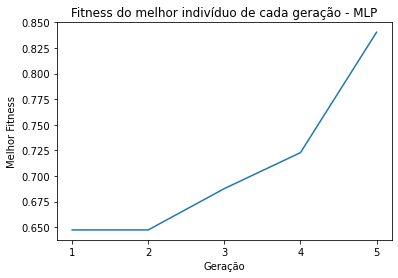

Selected Features: Index(['perimeter_se', 'radius_worst', 'smoothness_worst',
       'fractal_dimension_worst'],
      dtype='object')


In [13]:
best_individual = genetic_algorithm(X, y, population_size=50, num_generations=5, tournament_size=2)
selected_features = X.columns[np.where(best_individual == 1)[0]]
print("Selected Features:", selected_features)